In [1]:
#####################to be fixed!!

#!/usr/bin/env pythonP
# coding: utf-8

import netCDF4 as nc
import sys, os, argparse
import numpy as np
from numpy import ma as ma

#Import packages for plotting
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import matplotlib.animation as animation
from matplotlib.ticker import MaxNLocator
from pylab import imshow,cm
#Import packages for plotting
from matplotlib.colors import ListedColormap
from pylab import imshow,cm
import cartopy.crs as ccrs 
import cartopy.feature as cfeature  

#Import packages for clustering
from sklearn.cluster import KMeans
from scipy.linalg import eigh

#Import packages for geodesic distences
from pyproj import Geod

# Import package for parallel computing
from joblib import Parallel, delayed

from scipy.interpolate import griddata

year = 2009
season = "AMJ"
tmin = 29
time_steps_per_day=4
print(f"Processing year {year}, season {season}")


IC_resolution = 0.5
dt = 0.0025
DT = 0.1
# Format the variables
formatted_DT = f"{DT:.4f}"
formatted_dt = f"{dt:.4f}"

# Construct file paths and directories
Fmap_params = f"{year}_{season}_"
Fmap_params += f"ic{IC_resolution}_"
Fmap_params += f"dt{formatted_dt}_"
Fmap_params += f"DT{formatted_DT}"
directory =  f"/cluster/projects/nn8008k/lluisa/NextSIM/seas/" #f"/nird/projects/NS11048K/lluisa/NextSIM/rotated_ice_velocities/seas/AMJ/"
file_path = f"{directory}Fmap_10days/{Fmap_params}/"
parent_directory = "/cluster/home/llpui9007/Programs/HPC_Spectral_Clustering"
regrided_geo_file_path = f"{directory}OPA-neXtSIM_CREG025_ILBOXE140_{year}_ice_90Rx_{season}_regrided.nc"

NCores=32
K=1000
distance = 0

formatted_distance = f"{distance:.2f}"

clusters_path =  "/cluster/projects/nn8008k/lluisa/NextSIM/seas/Fmap_10days/2009_AMJ_ic0.5_dt0.0025_DT0.0100/clusters_K1000_border0.00_cleaned_center_spars/"
tmin=8

# Get the parent directory
parent_directory = "/cluster/home/llpui9007/Programs/HPC_Spectral_Clustering"
FTLE_parent_directory = "/cluster/home/llpui9007/Programs/FTLE"
TBarrier_parent_directory = "/cluster/home/llpui9007/Programs/TBarrier-main/TBarrier/2D"


# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/trajectory_advection")
sys.path.append(parent_directory+"/subfunctions/latlon_transform")
sys.path.append(parent_directory+"/utils")
sys.path.append(FTLE_parent_directory)
# add utils folder to current working path
sys.path.append(TBarrier_parent_directory+"/subfunctions/utils")
sys.path.append(TBarrier_parent_directory+"/subfunctions/integration")
# add FTLE folder to current working path
sys.path.append(TBarrier_parent_directory+"/demos/AdvectiveBarriers/FTLE2D")


# add utils folder to the TBarrier package
#sys.path.append(T_Barrier_directory+"/subfunctions/utils")
#sys.path.append(T_Barrier_directory+"/subfunctions/integration")
# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/Similarity_matrix_clustering")
sys.path.append(parent_directory+"/subfunctions/border_calculation")
sys.path.append(parent_directory+"/utils")
sys.path.append(parent_directory+"/subfunctions/Parallelisation")
from parallelised_functions import split

# Import linear interpolation function for unsteady flow field with irregular grid
from Interpolant import generate_mask_interpolator , generate_velocity_interpolants, interpolant_unsteady_FTLE, interpolant_FTLE
# Import function to compute flow map/particle trajectories
from regular_regrid import regular_grid_interpolation_scalar

# Import function to compute finite time Lyapunov exponent (FTLE)
from FTLE import parallel_FTLE
from polar_rotation import polar_rotation_rx 
from calculating_borders import borders_binary

ftle_path = "/cluster/projects/nn8008k/lluisa/NextSIM/seas/Fmap_10days/cleaned_FTLE_"+str(year)+"_"+season+"_dx0.100_dy0.100_dt0.100_grid_ratio0.010/"

print("Reading regrided input data")
"""
dataset = nc.Dataset(regrided_geo_file_path, mode='r')
# Access coordinates
X_domain = dataset.variables['regrided_rot_lat'][:]  
Y_domain = dataset.variables['regrided_rot_lon'][:]
dataset.close()
"""
domain_path = "/cluster/projects/nn8008k/lluisa/NextSIM/seas/Fmap_10days/"
X_domain = np.load(domain_path+"X_domain.npy")
Y_domain = np.load(domain_path+"Y_domain.npy")

FTLE_field = np.load(ftle_path + str(tmin) + "_FTLE.npy")
FTLE_field_plot = np.copy(FTLE_field)
mask = np.isnan(FTLE_field)
FTLE_field[np.isnan(FTLE_field)] = 0
Interpolant_FTLE = interpolant_unsteady_FTLE(X_domain, Y_domain, FTLE_field)


formatted_d=str(0)
spar=0
formatted_spar = f"{spar:.2f}"
FTLE = []


Processing year 2009, season AMJ
Reading regrided input data


In [2]:
def cut_trajectories(distance,land_mask,latitude,longitude,canadian=True, eastSval=True, canadian_greenland=True):
    from scipy.ndimage import binary_dilation
    # Define the number of cells to expand the mask
    # Create a structuring element for dilation
    structuring_element = np.ones((2 * distance + 1, 2 * distance + 1))
    # Perform binary dilation to expand the mask
    thick_land_mask = binary_dilation(land_mask, structure=structuring_element)
    from shapely.geometry import Point, Polygon

        #tangent canadian archipelago leaving greenland tail
    polygon_vertices = [
        (-25,-110),
        (-5,-83),   # Vertex 2 (latitude, longitude)
        (-45, -50),    # Vertex 4 (latitude, longitude)
        (-45, -100)
    ]
    # Create a Polygon object using shapely
    polygon = Polygon(polygon_vertices)
    # Flatten the latitude and longitude matrices to create a list of points
    points = np.column_stack((latitude.ravel(), longitude.ravel()))
    # Use a list comprehension to check if each point is inside the polygon
    inside_mask = np.array([polygon.contains(Point(lat, lon)) for lat, lon in points])
    # Reshape the mask back to the original shape of the latitude matrix
    polygon_land_mask = inside_mask.reshape(latitude.shape)
    
    # Count the number of points inside the polygon
    inside_points_count = np.sum(polygon_land_mask)

    if canadian_greenland==True:
        # Define the vertices of the polygon
        #tangent canadian archipelago
        polygon_vertices = [
            (-20,-110),
            (10, -50),   # Vertex 2 (latitude, longitude)
            (-35, -50),    # Vertex 4 (latitude, longitude)
            (-40, -90)
        ]
        # Create a Polygon object using shapely
        polygon = Polygon(polygon_vertices)
        # Flatten the latitude and longitude matrices to create a list of points
        points = np.column_stack((latitude.ravel(), longitude.ravel()))
        # Use a list comprehension to check if each point is inside the polygon
        inside_mask = np.array([polygon.contains(Point(lat, lon)) for lat, lon in points])
        # Reshape the mask back to the original shape of the latitude matrix
        polygon_land_mask = polygon_land_mask + inside_mask.reshape(latitude.shape)
        # Count the number of points inside the polygon
        inside_points_count = np.sum(polygon_land_mask)
    if eastSval==True:
        #east of svalbard
        polygon_vertices = [
            (26,-70),
            (15, -98),   # Vertex 2 (latitude, longitude)
            (-20, -52),    # Vertex 4 (latitude, longitude)
            (-4, -54)
        ]
        # Create a Polygon object using shapely
        polygon = Polygon(polygon_vertices)
        # Flatten the latitude and longitude matrices to create a list of points
        points = np.column_stack((latitude.ravel(), longitude.ravel()))
        # Use a list comprehension to check if each point is inside the polygon
        inside_mask = np.array([polygon.contains(Point(lat, lon)) for lat, lon in points])
        # Reshape the mask back to the original shape of the latitude matrix
        polygon_land_mask = polygon_land_mask + inside_mask.reshape(latitude.shape)
        
        # Count the number of points inside the polygon
        inside_points_count = np.sum(polygon_land_mask)
    
    
    # Output the number of points inside the polygon
    print("Number of points inside the polygons:")
    print(str(inside_points_count))
    expanded_land_mask = thick_land_mask + polygon_land_mask
    return expanded_land_mask

In [3]:
exp_mask = cut_trajectories(0,mask,Y_domain,X_domain,canadian=True, eastSval=True, canadian_greenland=True)

Number of points inside the polygons:
281832


In [ ]:
clusters_path =  "/cluster/projects/nn8008k/lluisa/NextSIM/seas/Fmap_10days/"+str(year)+"_"+season+"_ic0.5_dt0.0025_DT0.0100/disp_clusters_K1000_border0.00_cleaned_center_spars/" 

FTLE=[]
for n_clusters in range (2, 100): #:100):
    print("Processing "+str(n_clusters)+" clusters")
    Fmap_path = clusters_path+'tmin'+str(int(tmin))+'_spar'+str(formatted_spar)+'_labels'+'_Fmap_cut.npy'
    labels_path = clusters_path+str(n_clusters)+'_tmin'+str(int(tmin))+'_spar'+str(formatted_spar)+'_labels.npy'

    Fmap = np.load(Fmap_path)
    labels= np.load(labels_path)


    IC = Fmap[0,:,:]  #Take the position of the trajectory IC
    # Load the labels of the clusters
    grid_labels = griddata((IC[0, :], IC[1, :]), labels, (X_domain,Y_domain), method='nearest')
    fmap_mask = np.isnan(griddata((IC[0, :], IC[1, :]), labels, (X_domain,Y_domain), method='linear'))
    borders_avg = borders_binary(grid_labels)
    borders_avg = np.where(mask,np.nan, borders_avg)
    borders_idx = np.where(borders_avg==1)
    borders_lon_rot = X_domain[borders_idx]
    borders_lat_rot = Y_domain[borders_idx]
    FTLE.append(Interpolant_FTLE(borders_lat_rot, borders_lon_rot, grid=False))


mean_FTLE = []
idx = []
for i in range(0,len(FTLE)):
    mean_FTLE.append(np.mean(FTLE[i]))
    idx.append(2+i)

plt.plot(idx,mean_FTLE, ".")
plt.xlabel("Number of clusters",fontsize=16)
plt.ylabel("Average FTLE in borders",fontsize=16)
plt.title("FTLE in cluster borders vs number of clusters",fontsize=16)


Processing 2 clusters
Processing 3 clusters
Processing 4 clusters
Processing 5 clusters
Processing 6 clusters
Processing 7 clusters
Processing 8 clusters
Processing 9 clusters
Processing 10 clusters
Processing 11 clusters
Processing 12 clusters
Processing 13 clusters
Processing 14 clusters
Processing 15 clusters
Processing 16 clusters
Processing 17 clusters
Processing 18 clusters
Processing 19 clusters
Processing 20 clusters
Processing 21 clusters
Processing 22 clusters
Processing 23 clusters
Processing 24 clusters
Processing 25 clusters
Processing 26 clusters
Processing 27 clusters
Processing 28 clusters
Processing 29 clusters
Processing 30 clusters
Processing 31 clusters
Processing 32 clusters
Processing 33 clusters
Processing 34 clusters
Processing 35 clusters
Processing 36 clusters
Processing 37 clusters
Processing 38 clusters
Processing 39 clusters
Processing 40 clusters
Processing 41 clusters
Processing 42 clusters
Processing 43 clusters
Processing 44 clusters
Processing 45 clust

KeyboardInterrupt: 

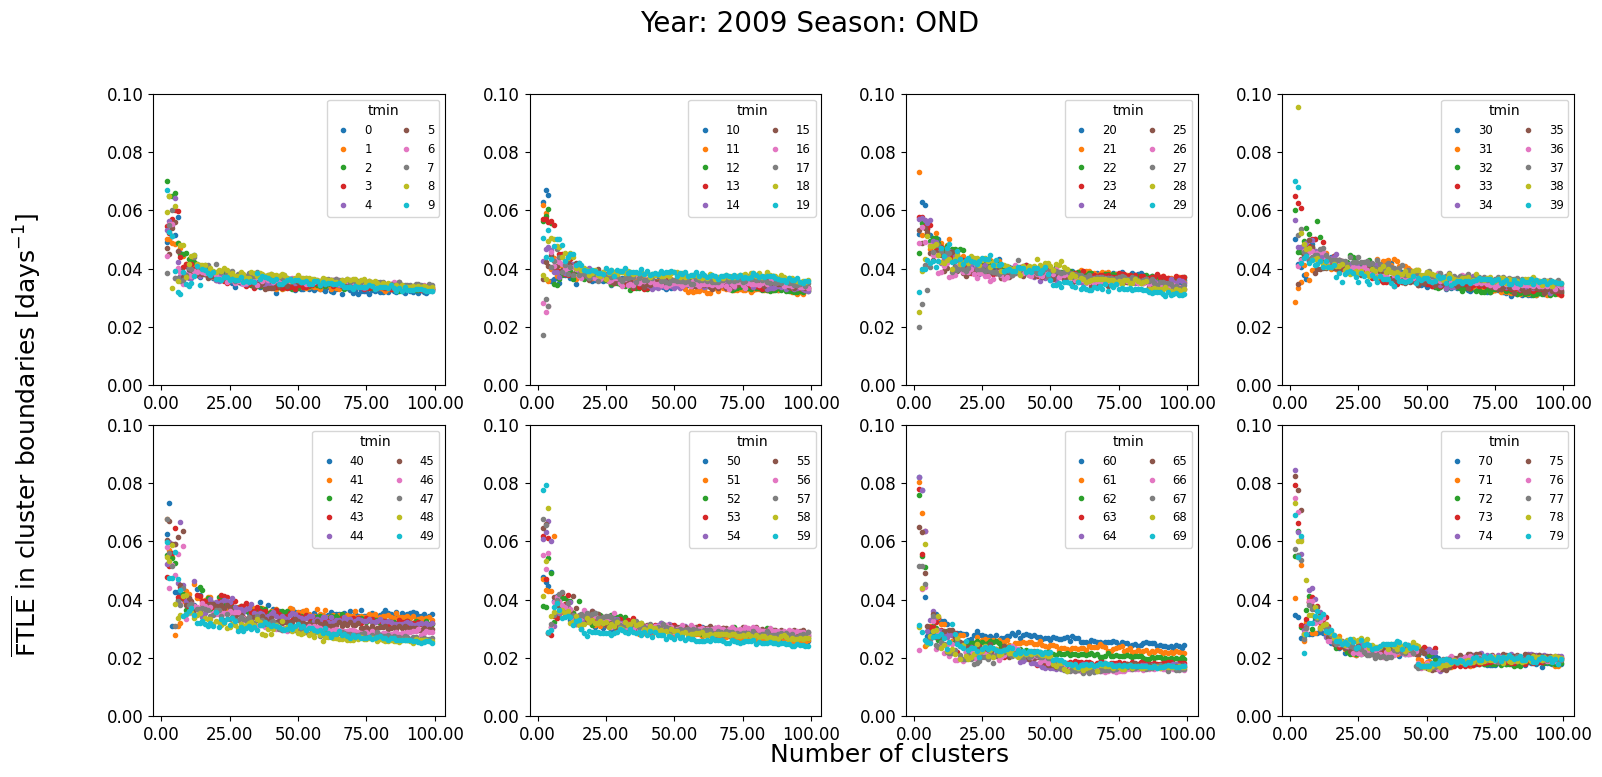

In [14]:
from matplotlib.ticker import FormatStrFormatter
# Define the path to the clusters
season="OND"
clusters_path = "/cluster/projects/nn8008k/lluisa/NextSIM/seas/Fmap_10days/" + str(year) + "_" + season + "_ic0.5_dt0.0025_DT0.0100/disp_clusters_K1000_border0.00_cleaned_center_spars/"
# Create the x-axis values
idx = []
for i in range(2, 100):
    idx.append(i)
# Create subplots: 8 subplots in a 4x2 grid
fig, axes = plt.subplots(2, 4, figsize=(16, 8))  # 4 rows, 2 columns
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing
# Loop through the data and plot in each subplot
for i, k in enumerate(range(0, 80, 10)):
    ax = axes[i]  # Select the current subplot
    for tmin in range(0 + k, 10 + k):
        ftle_borders_path = clusters_path + "2_100_FTLE_interpol_" + str(tmin) + ".npy"
        ftle_borders = np.load(ftle_borders_path)
        ax.plot(idx, ftle_borders, '.', label=str(tmin))
        # Set number of decimals for tick labels
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # X-axis ticks to 2 decimals
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # Y-axis ticks to 2 decimals
        # Set tick size
        ax.tick_params(axis='both', which='major', labelsize=12)  # Major tick size
        ax.tick_params(axis='both', which='minor', labelsize=12)  # Minor tick size
    
    # Add title and legend to each subplot
    #ax.set_title(f"Plots for k={k}")
    ax.set_ylim(0,0.1)
    ax.legend(title="tmin", fontsize='small', loc='upper right',ncols=2)
    ax.set_box_aspect(1)
# Add a supertitle
fig.suptitle("Year: " + str(year) + " Season: " + str(season), fontsize=20)
# Add a single xlabel and ylabel for the entire figure
fig.text(0.55, 0.04, "Number of clusters", ha="center", fontsize=18)  # X-axis label
fig.text(0.0, 0.45, r"$\overline{\mathrm{FTLE}}$ in cluster boundaries [days$^{-1}$] ", va="center", rotation="vertical", fontsize=18)  # Y-axis label
# Adjust layout to prevent overlap
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])  # Leave space for the supertitle and axis labels
# Show the plots
plt.show()

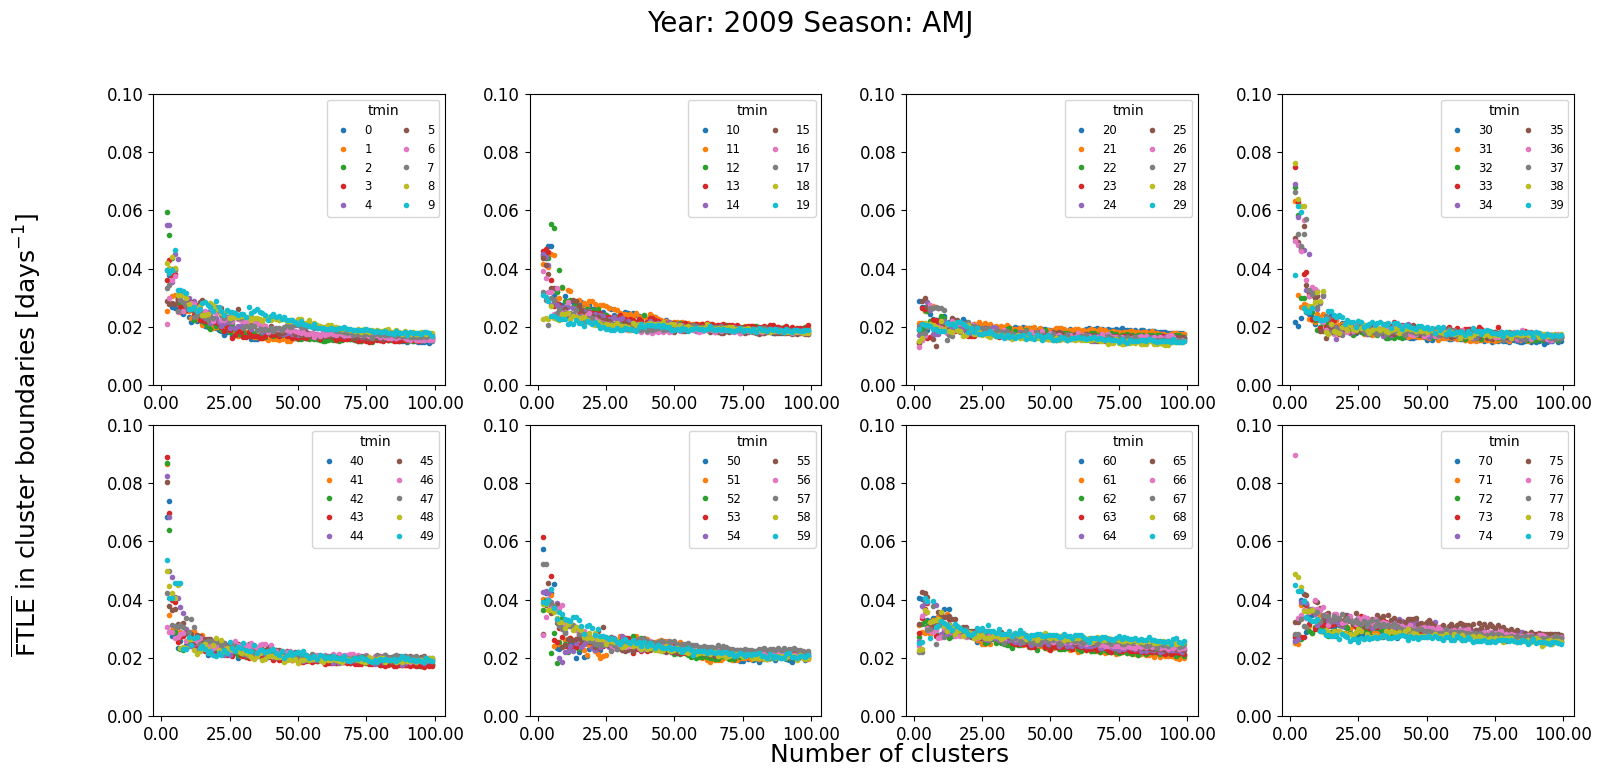

In [15]:
from matplotlib.ticker import FormatStrFormatter
# Define the path to the clusters
season="AMJ"
clusters_path = "/cluster/projects/nn8008k/lluisa/NextSIM/seas/Fmap_10days/" + str(year) + "_" + season + "_ic0.5_dt0.0025_DT0.0100/disp_clusters_K1000_border0.00_cleaned_center_spars/"
# Create the x-axis values
idx = []
for i in range(2, 100):
    idx.append(i)
# Create subplots: 8 subplots in a 4x2 grid
fig, axes = plt.subplots(2, 4, figsize=(16, 8))  # 4 rows, 2 columns
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing
# Loop through the data and plot in each subplot
for i, k in enumerate(range(0, 80, 10)):
    ax = axes[i]  # Select the current subplot
    for tmin in range(0 + k, 10 + k):
        ftle_borders_path = clusters_path + "2_100_FTLE_interpol_" + str(tmin) + ".npy"
        ftle_borders = np.load(ftle_borders_path)
        ax.plot(idx, ftle_borders, '.', label=str(tmin))
        # Set number of decimals for tick labels
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # X-axis ticks to 2 decimals
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # Y-axis ticks to 2 decimals
        # Set tick size
        ax.tick_params(axis='both', which='major', labelsize=12)  # Major tick size
        ax.tick_params(axis='both', which='minor', labelsize=12)  # Minor tick size
    
    # Add title and legend to each subplot
    #ax.set_title(f"Plots for k={k}")
    ax.set_ylim(0,0.1)
    ax.legend(title="tmin", fontsize='small', loc='upper right',ncols=2)
    ax.set_box_aspect(1)
# Add a supertitle
fig.suptitle("Year: " + str(year) + " Season: " + str(season), fontsize=20)
# Add a single xlabel and ylabel for the entire figure
fig.text(0.55, 0.04, "Number of clusters", ha="center", fontsize=18)  # X-axis label
fig.text(0.0, 0.45, r"$\overline{\mathrm{FTLE}}$ in cluster boundaries [days$^{-1}$] ", va="center", rotation="vertical", fontsize=18)  # Y-axis label
# Adjust layout to prevent overlap
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])  # Leave space for the supertitle and axis labels
# Show the plots
plt.show()

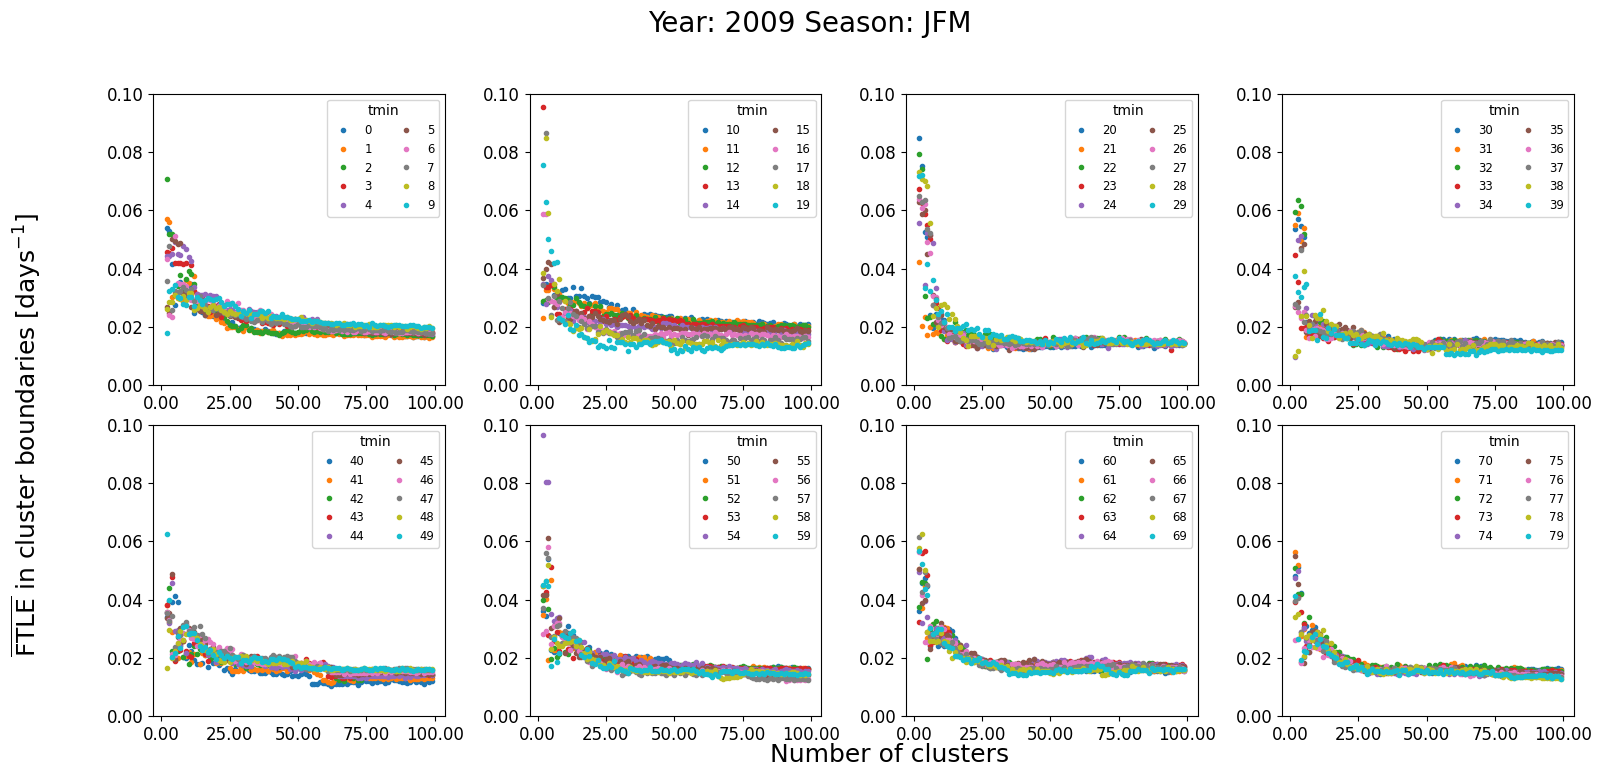

In [16]:
from matplotlib.ticker import FormatStrFormatter
# Define the path to the clusters
season="JFM"
clusters_path = "/cluster/projects/nn8008k/lluisa/NextSIM/seas/Fmap_10days/" + str(year) + "_" + season + "_ic0.5_dt0.0025_DT0.0100/disp_clusters_K1000_border0.00_cleaned_center_spars/"
# Create the x-axis values
idx = []
for i in range(2, 100):
    idx.append(i)
# Create subplots: 8 subplots in a 4x2 grid
fig, axes = plt.subplots(2, 4, figsize=(16, 8))  # 4 rows, 2 columns
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing
# Loop through the data and plot in each subplot
for i, k in enumerate(range(0, 80, 10)):
    ax = axes[i]  # Select the current subplot
    for tmin in range(0 + k, 10 + k):
        ftle_borders_path = clusters_path + "2_100_FTLE_interpol_" + str(tmin) + ".npy"
        ftle_borders = np.load(ftle_borders_path)
        ax.plot(idx, ftle_borders, '.', label=str(tmin))
        # Set number of decimals for tick labels
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # X-axis ticks to 2 decimals
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # Y-axis ticks to 2 decimals
        # Set tick size
        ax.tick_params(axis='both', which='major', labelsize=12)  # Major tick size
        ax.tick_params(axis='both', which='minor', labelsize=12)  # Minor tick size
    
    # Add title and legend to each subplot
    #ax.set_title(f"Plots for k={k}")
    ax.set_ylim(0,0.1)
    ax.legend(title="tmin", fontsize='small', loc='upper right',ncols=2)
    ax.set_box_aspect(1)
# Add a supertitle
fig.suptitle("Year: " + str(year) + " Season: " + str(season), fontsize=20)
# Add a single xlabel and ylabel for the entire figure
fig.text(0.55, 0.04, "Number of clusters", ha="center", fontsize=18)  # X-axis label
fig.text(0.0, 0.45, r"$\overline{\mathrm{FTLE}}$ in cluster boundaries [days$^{-1}$] ", va="center", rotation="vertical", fontsize=18)  # Y-axis label
# Adjust layout to prevent overlap
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])  # Leave space for the supertitle and axis labels
# Show the plots
plt.show()

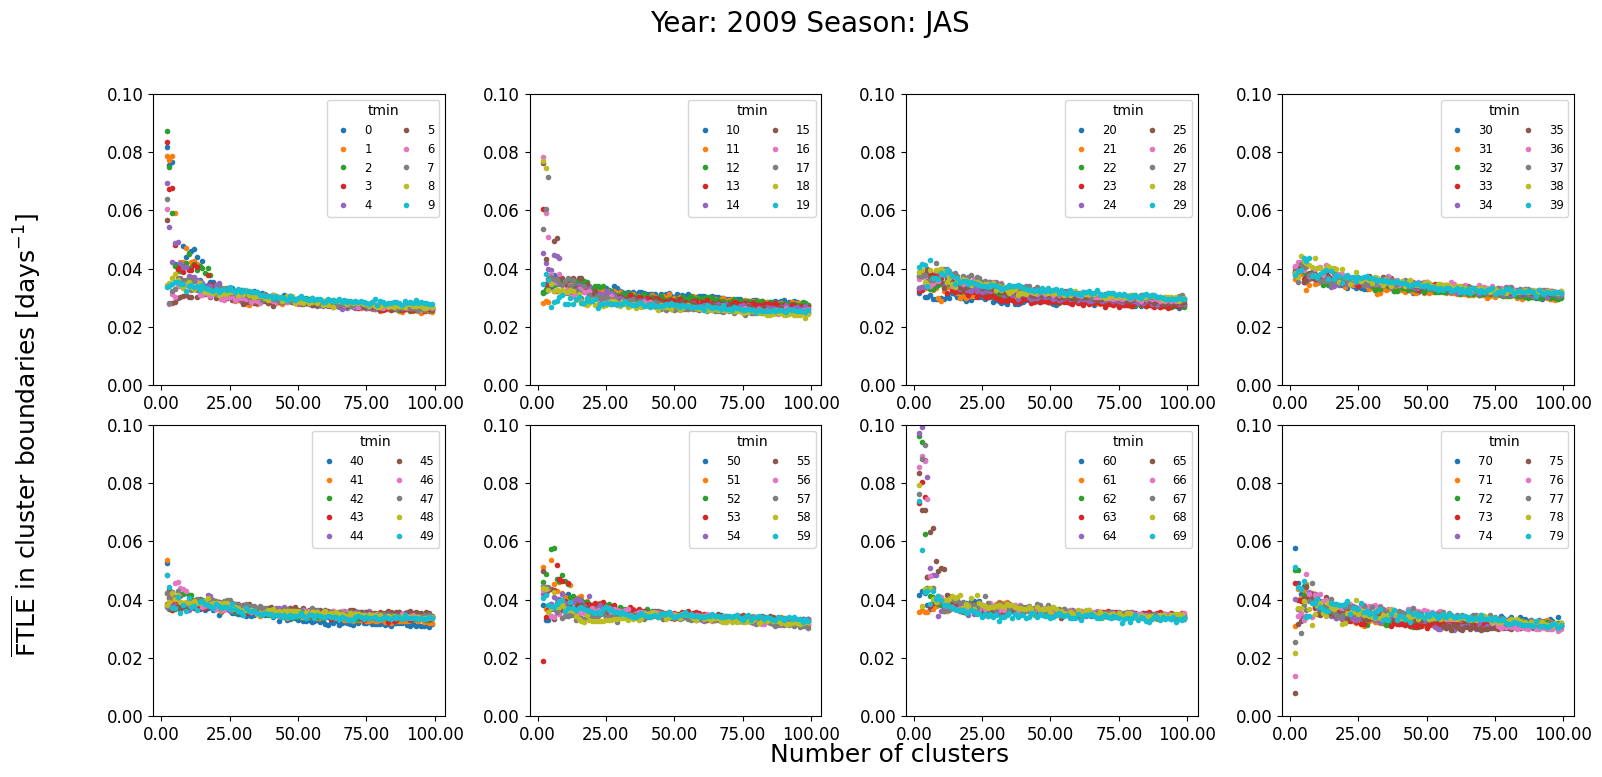

In [17]:
from matplotlib.ticker import FormatStrFormatter
# Define the path to the clusters
season="JAS"
clusters_path = "/cluster/projects/nn8008k/lluisa/NextSIM/seas/Fmap_10days/" + str(year) + "_" + season + "_ic0.5_dt0.0025_DT0.0100/disp_clusters_K1000_border0.00_cleaned_center_spars/"
# Create the x-axis values
idx = []
for i in range(2, 100):
    idx.append(i)
# Create subplots: 8 subplots in a 4x2 grid
fig, axes = plt.subplots(2, 4, figsize=(16, 8))  # 4 rows, 2 columns
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing
# Loop through the data and plot in each subplot
for i, k in enumerate(range(0, 80, 10)):
    ax = axes[i]  # Select the current subplot
    for tmin in range(0 + k, 10 + k):
        ftle_borders_path = clusters_path + "2_100_FTLE_interpol_" + str(tmin) + ".npy"
        ftle_borders = np.load(ftle_borders_path)
        ax.plot(idx, ftle_borders, '.', label=str(tmin))
        # Set number of decimals for tick labels
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # X-axis ticks to 2 decimals
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # Y-axis ticks to 2 decimals
        # Set tick size
        ax.tick_params(axis='both', which='major', labelsize=12)  # Major tick size
        ax.tick_params(axis='both', which='minor', labelsize=12)  # Minor tick size
    
    # Add title and legend to each subplot
    #ax.set_title(f"Plots for k={k}")
    ax.set_ylim(0,0.1)
    ax.legend(title="tmin", fontsize='small', loc='upper right',ncols=2)
    ax.set_box_aspect(1)
# Add a supertitle
fig.suptitle("Year: " + str(year) + " Season: " + str(season), fontsize=20)
# Add a single xlabel and ylabel for the entire figure
fig.text(0.55, 0.04, "Number of clusters", ha="center", fontsize=18)  # X-axis label
fig.text(0.0, 0.45, r"$\overline{\mathrm{FTLE}}$ in cluster boundaries [days$^{-1}$] ", va="center", rotation="vertical", fontsize=18)  # Y-axis label
# Adjust layout to prevent overlap
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])  # Leave space for the supertitle and axis labels
# Show the plots
plt.show()

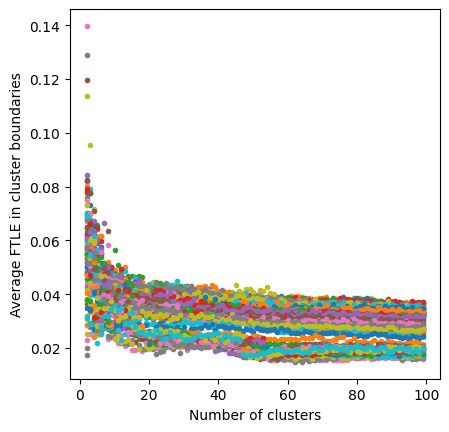

In [23]:
# Define the path to the clusters
season = "OND"
year = 2009 # Example year
clusters_path =  "/cluster/projects/nn8008k/lluisa/NextSIM/seas/Fmap_10days/"+str(year)+"_"+season+"_ic0.5_dt0.0025_DT0.0100/disp_clusters_K1000_border0.00_cleaned_center_spars/" 
# Create the x-axis values
idx = []
for i in range(2, 100):
    idx.append(i)
# Create a figure and axis
fig, ax = plt.subplots()  # Create a figure and a single axis
# Loop through the data and plot
for tmin in range(0, 80):
    ftle_borders_path = clusters_path + "2_100_FTLE_interpol_" + str(tmin) + ".npy"
    ftle_borders = np.load(ftle_borders_path)
    ax.plot(idx, ftle_borders, '.', label=str(tmin))
# Set labels
ax.set_xlabel("Number of clusters")
ax.set_ylabel("Average FTLE in cluster boundaries")
# Set the aspect ratio of the plot to be square
ax.set_box_aspect(1)  # Ensures the plot is square
# Show the plot
plt.show()
plt.close()

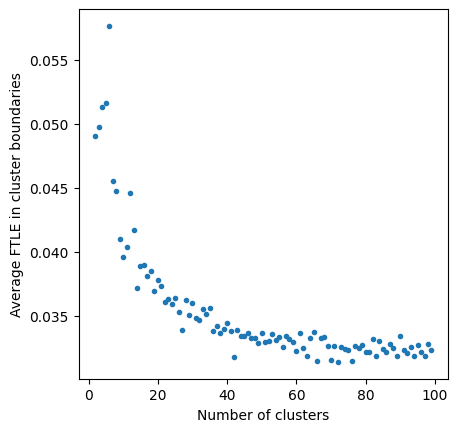

In [31]:
# Define the path to the clusters
season = "OND"
year = 2009 # Example year
clusters_path =  "/cluster/projects/nn8008k/lluisa/NextSIM/seas/Fmap_10days/"+str(year)+"_"+season+"_ic0.5_dt0.0025_DT0.0100/disp_clusters_K1000_border0.00_cleaned_center_spars/" 
# Create the x-axis values
idx = []
for i in range(2, 100):
    idx.append(i)
# Create a figure and axis

# Loop through the data and plot
tmin = 0
plt.close(fig)
fig, ax = plt.subplots()  # Create a figure and a single axis
ftle_borders_path = clusters_path + "2_100_FTLE_interpol_" + str(tmin) + ".npy"
ftle_borders = np.load(ftle_borders_path)
ax.plot(idx, ftle_borders, '.', label=str(tmin))
# Set labels
ax.set_xlabel("Number of clusters")
ax.set_ylabel("Average FTLE in cluster boundaries")
# Set the aspect ratio of the plot to be square
ax.set_box_aspect(1)  # Ensures the plot is square
# Show the plot
fig.show()
#plt.close(fig)
   

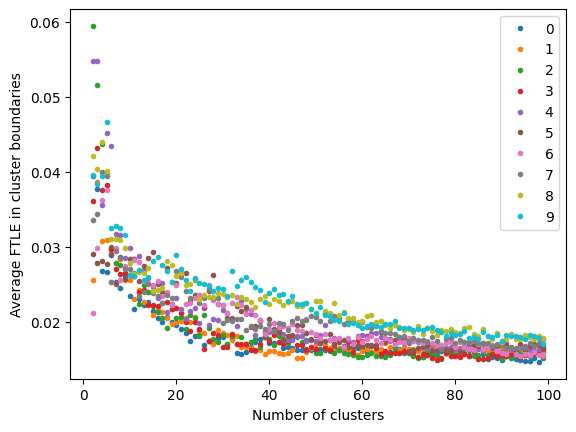

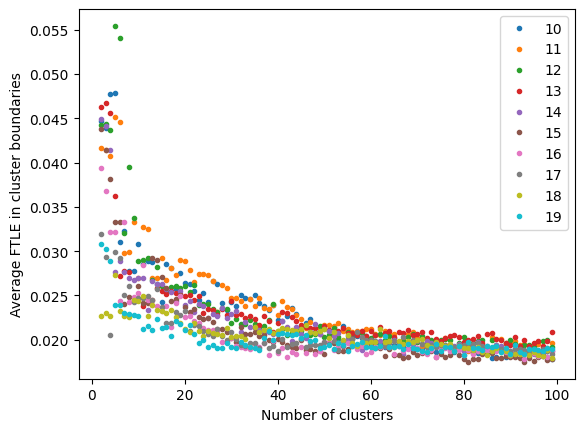

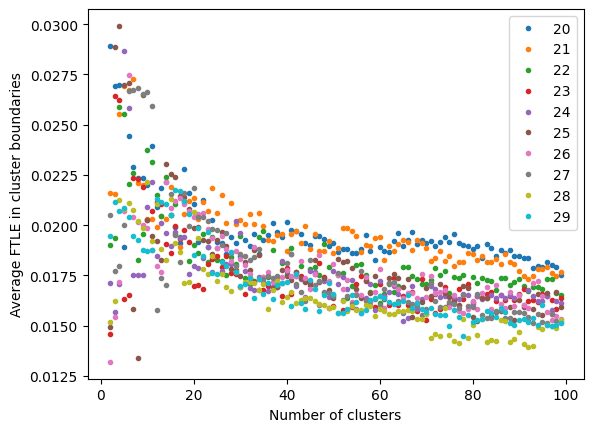

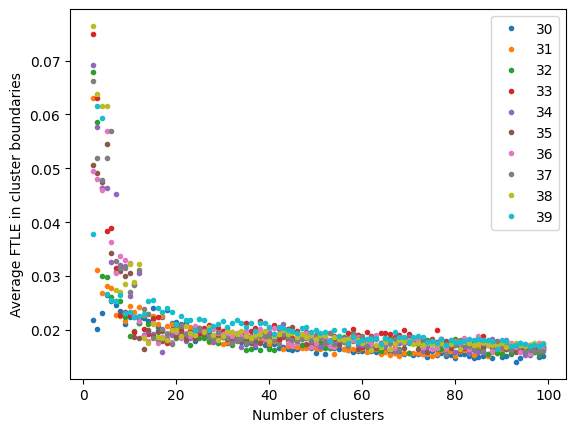

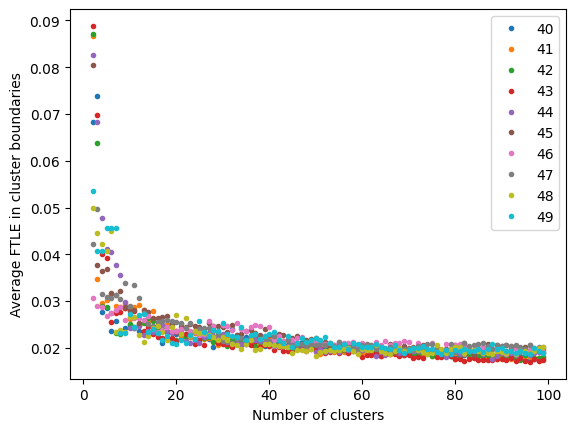

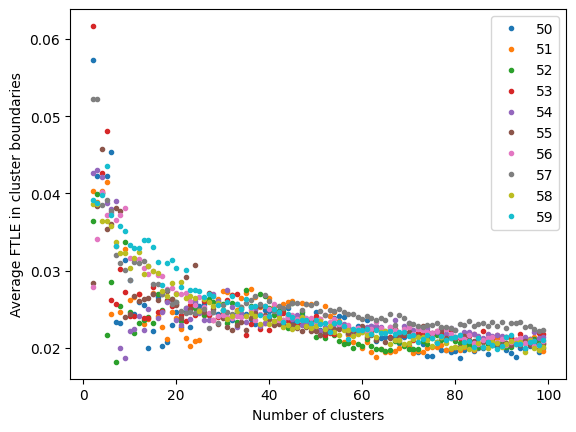

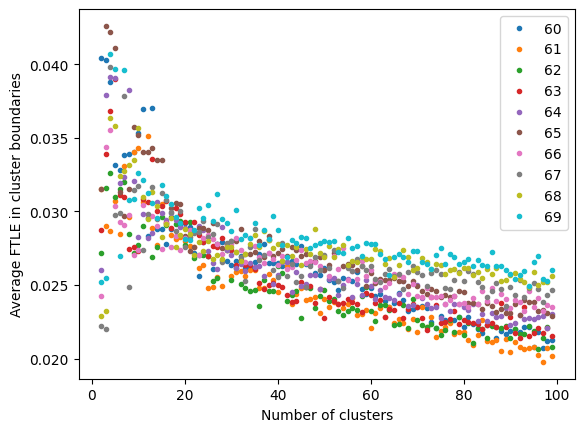

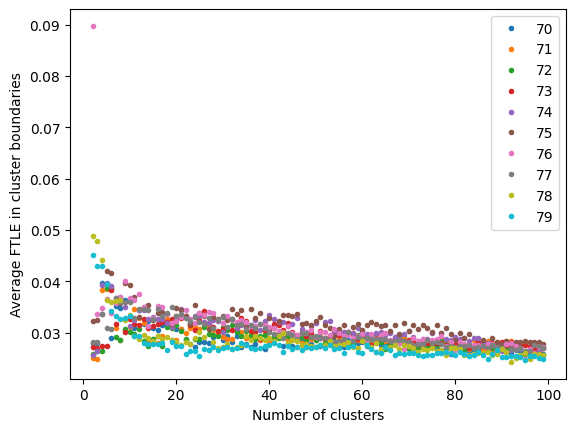

In [15]:
clusters_path =  "/cluster/projects/nn8008k/lluisa/NextSIM/seas/Fmap_10days/"+str(year)+"_"+season+"_ic0.5_dt0.0025_DT0.0100/disp_clusters_K1000_border0.00_cleaned_center_spars/" 

idx=[]
for i in range(2,100):
    idx.append(i)
for k in range(0,80,10):
    for tmin in range (0+k, 10+k):
        ftle_borders_path = clusters_path+"2_100_FTLE_interpol_"+str(tmin)+".npy"
        ftle_borders = np.load(ftle_borders_path)
        plt.plot(idx,ftle_borders,'.',label=str(tmin))
    plt.xlabel("Number of clusters")
    plt.ylabel("Average FTLE in cluster boundaries")
    plt.legend()
    plt.show()
    plt.close()

In [17]:
season

'AMJ'

In [ ]:

np.save(clusters_path+"/2_100_FTLE_interpol_"+str(tmin)+".npy", FTLE)
print("ftle.npy saved")
plt.savefig(clusters_path+"/2_100_FTLE_interpol_"+str(tmin)+".png")

In [ ]:

np.save(clusters_path+"/2_100_FTLE_interpol_"+str(tmin)+".npy", FTLE)
print("ftle.npy saved")
plt.savefig(clusters_path+"/2_100_FTLE_interpol_"+str(tmin)+".png")